In [ ]:
!pip install shap lime --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd

# Load dataset (upload manually in Colab or use a path if available)
from google.colab import files
uploaded = files.upload()

# Read CSV
df = pd.read_csv('bank.csv')
print("Dataset shape:", df.shape)
df.head()


Saving bank.csv to bank (1).csv
Dataset shape: (11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
label_encoders = {}

for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

df_encoded.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Features and target
X = df_encoded.drop('deposit', axis=1)
y = df_encoded['deposit']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)

logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(random_state=42)

Logistic Regression - F1 Score: 0.7690, ROC AUC: 0.8549


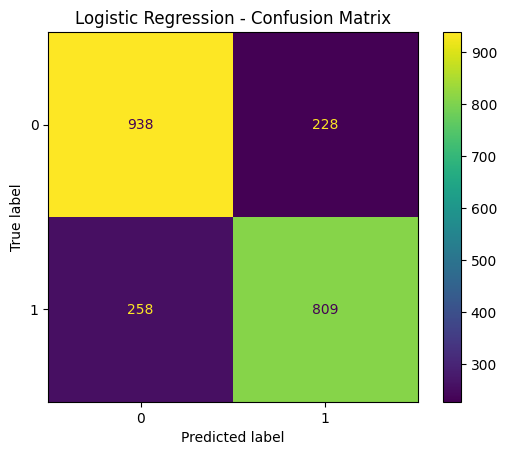

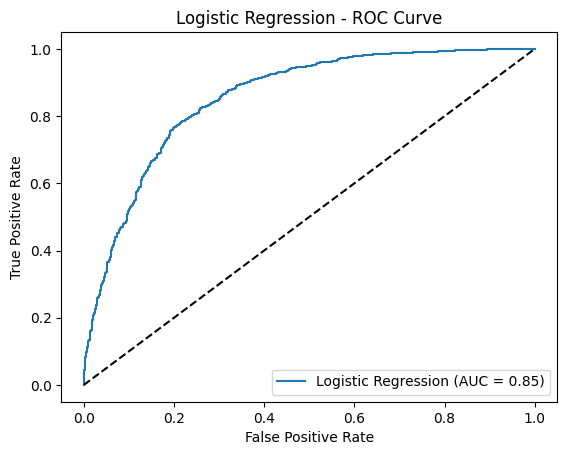

Random Forest - F1 Score: 0.8301, ROC AUC: 0.9097


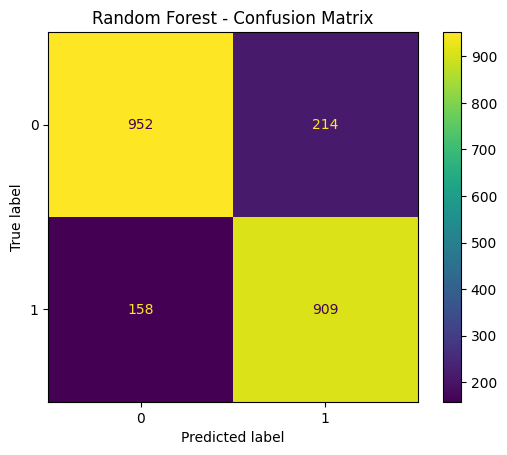

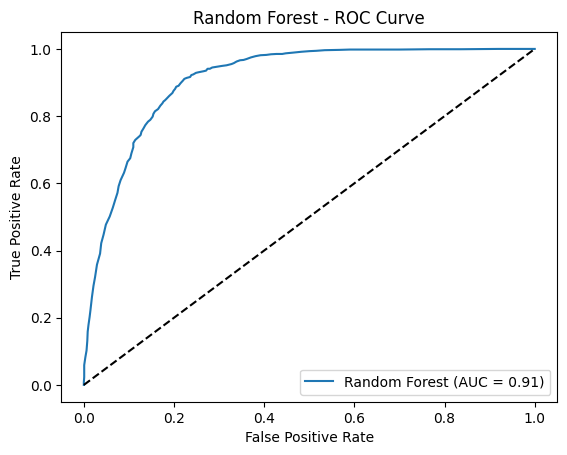

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"{name} - F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC Curve')
    plt.legend()
    plt.show()

# Evaluate both models
evaluate_model(logreg, "Logistic Regression")
evaluate_model(rf, "Random Forest")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


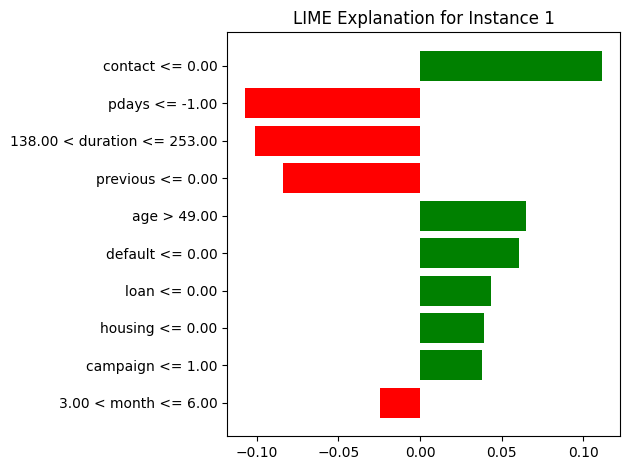

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


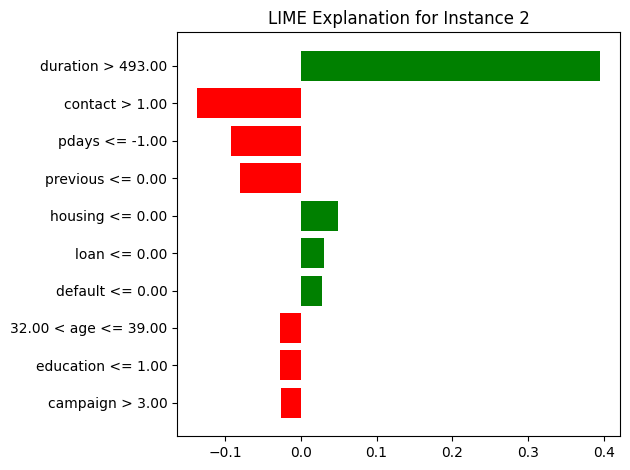

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


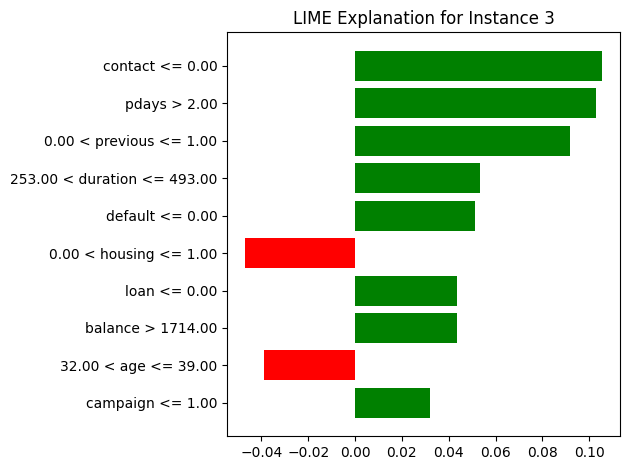

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


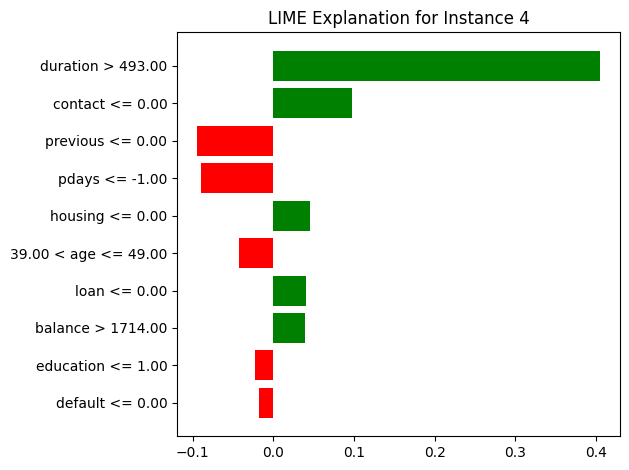

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


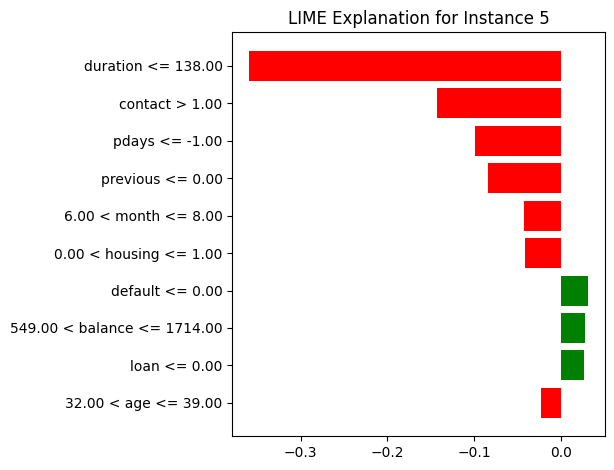

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize LIME
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=["No", "Yes"],
    mode="classification"
)

# Explain 5 predictions
for i in range(5):
    exp = lime_explainer.explain_instance(
        data_row=X_test.iloc[i].values,
        predict_fn=rf.predict_proba,
        num_features=10
    )
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Explanation for Instance {i+1}')
    plt.tight_layout()
    plt.show()


**TASK 2**

In [ ]:
import pandas as pd

from google.colab import files
uploaded = files.upload()

df = pd.read_csv('Mall_Customers.csv')
df.head()


Saving Mall_Customers.csv to Mall_Customers.csv


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


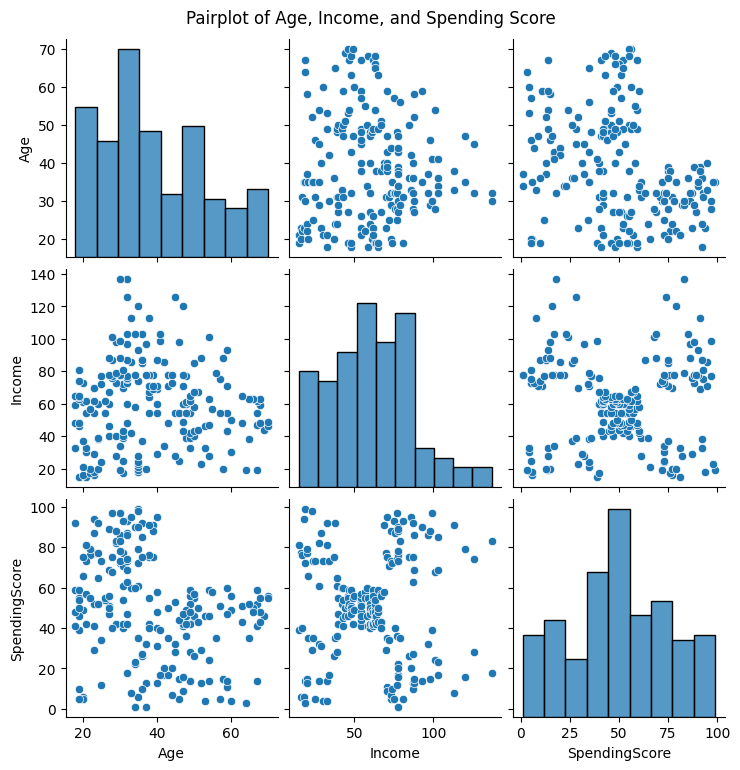

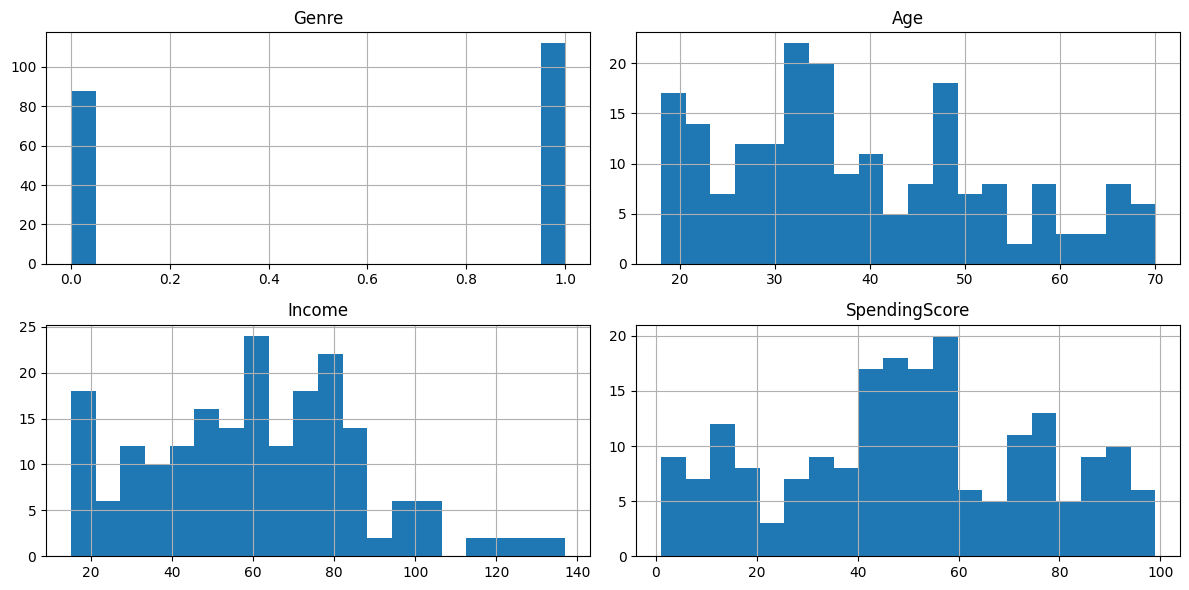

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df.rename(columns={
    'Annual Income (k$)': 'Income',
    'Spending Score (1-100)': 'SpendingScore'
}, inplace=True)

df['Genre'] = df['Genre'].map({'Male': 0, 'Female': 1})
df = df.drop(columns=['CustomerID'])

# Pairplot
sns.pairplot(df[['Age', 'Income', 'SpendingScore']])
plt.suptitle("Pairplot of Age, Income, and Spending Score", y=1.02)
plt.show()

# Histograms
df.hist(figsize=(12, 6), bins=20)
plt.tight_layout()
plt.show()


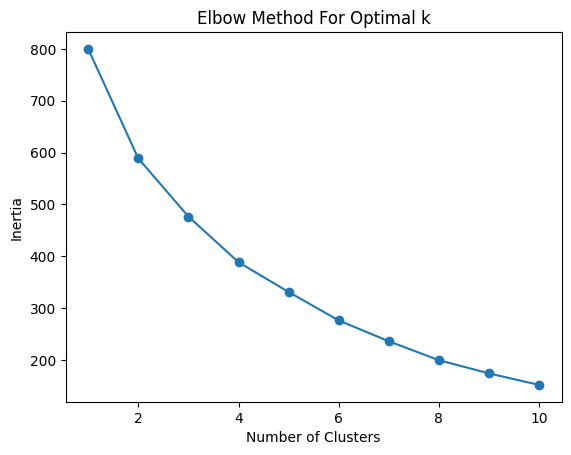

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

# Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# KMeans with optimal k
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_df)


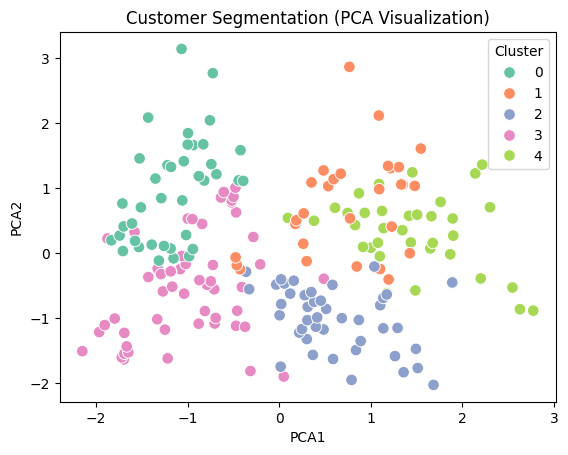

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(scaled_df)
df['PCA1'] = components[:, 0]
df['PCA2'] = components[:, 1]

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=70)
plt.title("Customer Segmentation (PCA Visualization)")
plt.show()


In [ ]:
# Analyze mean characteristics of each cluster
cluster_summary = df.groupby('Cluster').mean().round(1)
print(cluster_summary)


         Genre   Age  Income  SpendingScore  PCA1  PCA2
Cluster                                                
0          0.5  32.7    86.5           82.1  -1.2   1.0
1          0.6  36.5    89.5           18.0   0.7   0.7
2          1.0  49.8    49.2           40.1   0.6  -1.0
3          0.6  24.9    39.7           61.2  -1.0  -0.5
4          0.0  55.7    53.7           36.8   1.5   0.3


**TASK 3**

In [ ]:
# STEP 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# STEP 2: LOAD AND CLEAN DATA
df = pd.read_csv('household_power_consumption.csv', sep=',', na_values='?', low_memory=False)

# Combine 'Date' and 'Time'
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%d/%m/%Y %H:%M:%S", errors='coerce')

# Drop invalid entries
df.dropna(subset=['Datetime', 'Global_active_power'], inplace=True)

# Set datetime index
df.set_index('Datetime', inplace=True)

# Resample to hourly mean
df_hourly = df['Global_active_power'].resample('H').mean().dropna()


/tmp/ipython-input-21-895427742.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df['Global_active_power'].resample('H').mean().dropna()


In [ ]:
df_feat = df_hourly.to_frame()
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['is_weekend'] = (df_feat['dayofweek'] >= 5).astype(int)
df_feat.head()


,Global_active_power,hour,dayofweek,is_weekend
Datetime,,,,
2006-12-16 17:00:00,4.222889,17,5,1
2006-12-16 18:00:00,3.632200,18,5,1
2006-12-16 19:00:00,3.400233,19,5,1
2006-12-16 20:00:00,3.268567,20,5,1
2006-12-16 21:00:00,3.056467,21,5,1


In [ ]:
!pip install statsmodels --quiet



In [ ]:
print(df_hourly.index.min())
print(df_hourly.index.max())


2006-12-16 17:00:00
2008-12-13 21:00:00


In [ ]:
# Check range first
start_date = df_hourly.index.min()
end_date = df_hourly.index.max()

print("Start:", start_date)
print("End:", end_date)


Start: 2006-12-16 17:00:00
End: 2008-12-13 21:00:00


In [ ]:
# Use a valid date range — adjust based on your data
train = df_hourly[:'2007-06']
test = df_hourly['2008-07']


In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import numpy as np

# Re-train using correct date slices
model = sm.tsa.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,24))
results = model.fit()

forecast_sarimax = results.predict(start=len(train), end=len(train)+len(test)-1)

print("SARIMAX RMSE:", np.sqrt(mean_squared_error(test, forecast_sarimax)))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMAX RMSE: 0.5669738539089578


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
print(df_prophet['ds'].min())
print(df_prophet['ds'].max())


2006-12-16 17:00:00
2008-12-13 21:00:00


In [ ]:
df_prophet.tail()


,ds,y
17410,2008-12-13 17:00:00,2.755267
17411,2008-12-13 18:00:00,1.329000
17412,2008-12-13 19:00:00,2.258433
17413,2008-12-13 20:00:00,1.472700
17414,2008-12-13 21:00:00,0.367128


In [ ]:
# Try an earlier date based on actual range
split_date = '2008-10-01'  # <== change if needed

train_prophet = df_prophet[df_prophet['ds'] <= split_date]
test_prophet = df_prophet[df_prophet['ds'] > split_date]


In [ ]:
print("Train size:", len(train_prophet))
print("Test size:", len(test_prophet))


Train size: 15642
Test size: 1773


In [ ]:
# Re-train
prophet_model = Prophet()
prophet_model.fit(train_prophet)

# Forecast future
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='h')
forecast = prophet_model.predict(future)

# Evaluate Prophet predictions
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], forecast['yhat'][-len(test_prophet):]))
print("✅ Prophet RMSE:", rmse_prophet)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptn29lrmf/pspukunb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptn29lrmf/nijkg4a4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14602', 'data', 'file=/tmp/tmptn29lrmf/pspukunb.json', 'init=/tmp/tmptn29lrmf/nijkg4a4.json', 'output', 'file=/tmp/tmptn29lrmf/prophet_modelfens10lj/prophet_model-20250716144510.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:45:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:45:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Prophet RMSE: 1.151539601505154


In [ ]:
print("Start:", X.index.min())
print("End  :", X.index.max())


Start: 2006-12-17 17:00:00
End  : 2008-12-13 21:00:00


In [ ]:
# Use valid training and test ranges
X_train = X.loc['2006-12-18':'2008-06-30']
X_test  = X.loc['2008-07-01':'2008-12-01']

y_train = y.loc['2006-12-18':'2008-06-30']
y_test  = y.loc['2008-07-01':'2008-12-01']



In [ ]:
print("✅ X_train:", X_train.shape)
print("✅ y_train:", y_train.shape)
print("✅ X_test :", X_test.shape)
print("✅ y_test :", y_test.shape)


✅ X_train: (13402, 27)
✅ y_train: (13402,)
✅ X_test : (3696, 27)
✅ y_test : (3696,)


In [ ]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
xgb_preds = model_xgb.predict(X_test)


/tmp/ipython-input-57-3329258166.py:23: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


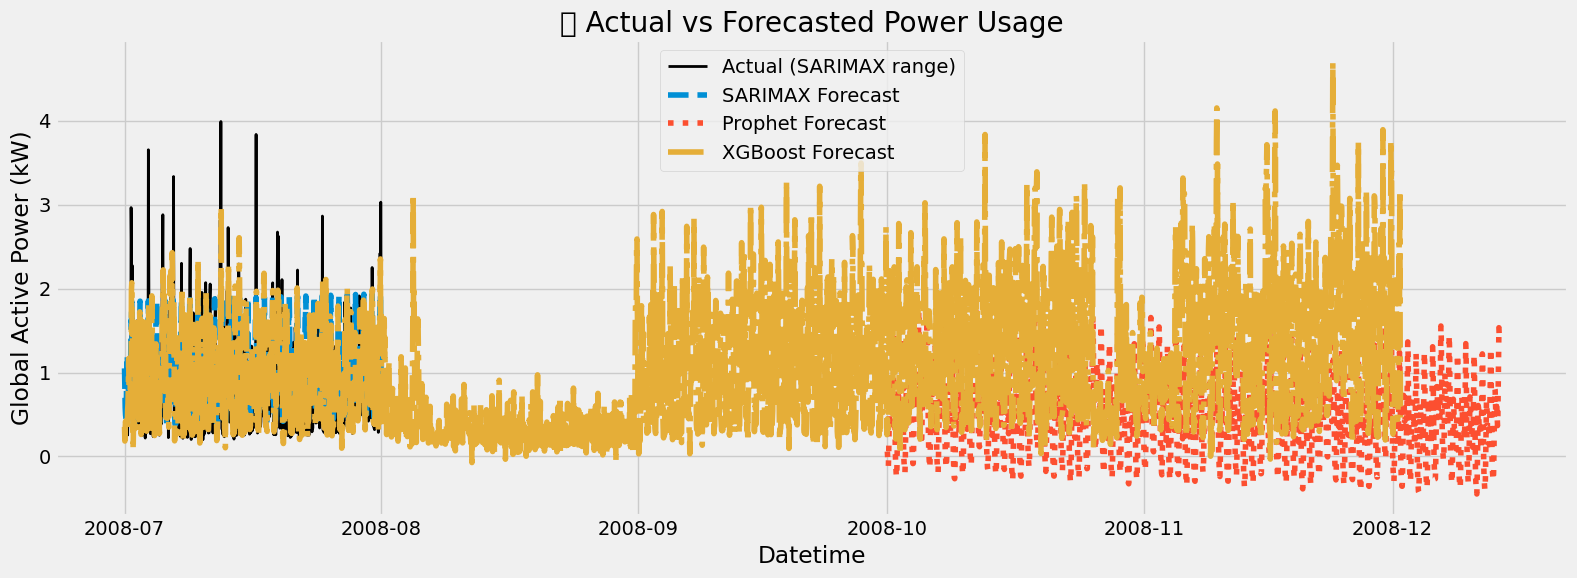

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# Actual values
plt.plot(test.index, test, label='Actual (SARIMAX range)', color='black', linewidth=2)

# SARIMAX Forecast
plt.plot(test.index, forecast_sarimax, label='SARIMAX Forecast', linestyle='--')

# Prophet Forecast
plt.plot(test_prophet['ds'], forecast['yhat'][-len(test_prophet):], label='Prophet Forecast', linestyle='dotted')

# XGBoost Forecast
plt.plot(y_test.index, xgb_preds, label='XGBoost Forecast', linestyle='dashdot')

# Plot settings
plt.title("📈 Actual vs Forecasted Power Usage")
plt.xlabel("Datetime")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

print("🔎 RMSE Comparison:")
print(f" - SARIMAX : {np.sqrt(mean_squared_error(test, forecast_sarimax)):.4f}")
print(f" - Prophet : {np.sqrt(mean_squared_error(test_prophet['y'], forecast['yhat'][-len(test_prophet):])):.4f}")
print(f" - XGBoost : {np.sqrt(mean_squared_error(y_test, xgb_preds)):.4f}")


🔎 RMSE Comparison:
 - SARIMAX : 0.5670
 - Prophet : 1.1515
 - XGBoost : 0.5191


**TASK 4**

In [3]:
import pandas as pd

# Main tables
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

# Related tables
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
pos_cash_balance = pd.read_csv('POS_CASH_balance.csv')
previous_application = pd.read_csv('previous_application.csv')
installments_payments = pd.read_csv('installments_payments.csv')

# Optional: Description of all columns
columns_description = pd.read_csv('HomeCredit_columns_description.csv', encoding='ISO-8859-1')  # encoding to avoid error


In [4]:
print(app_train.shape)
print(app_train.columns)
app_train.head()

(307511, 122)
Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Remove rows with missing target
app_train = app_train[~app_train['TARGET'].isnull()]

# Separate target
y = app_train['TARGET']
X = app_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)

# For simplicity: drop columns with too many nulls and convert categoricals
X = X.dropna(axis=1, thresh=int(0.7 * X.shape[0]))  # keep cols with <30% nulls
X = X.fillna(-999)  # simple imputation
X = pd.get_dummies(X)  # one-hot encode categoricals

# Align with test data
X_test_final = app_test.drop(['SK_ID_CURR'], axis=1)
X_test_final = X_test_final[X.columns.intersection(X_test_final.columns)]
X_test_final = X_test_final.fillna(-999)
X_test_final = pd.get_dummies(X_test_final)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Logistic Regression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)
probs_lr = model_lr.predict_proba(X_val)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.5 MB/s eta 0:00:00


In [12]:
from catboost import CatBoostClassifier



In [13]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train CatBoost model
model_cb = CatBoostClassifier(verbose=0, random_state=42)
model_cb.fit(X_train, y_train)

# Get predicted probabilities for class 1 (default)
probs_cb = model_cb.predict_proba(X_val)[:, 1]


In [14]:
import numpy as np

# Custom function to calculate business cost
def calculate_cost(y_true, y_probs, threshold, FP_cost=5000, FN_cost=500):
    y_pred = (y_probs >= threshold).astype(int)
    FP = np.sum((y_pred == 1) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    total_cost = FP * FP_cost + FN * FN_cost
    return total_cost, FP, FN

# Try different thresholds
thresholds = np.linspace(0.1, 0.9, 50)
costs = [calculate_cost(y_val.values, probs_cb, t)[0] for t in thresholds]

# Find optimal threshold
optimal_threshold = thresholds[np.argmin(costs)]
print("Optimal threshold:", optimal_threshold)


Optimal threshold: 0.8020408163265307


In [15]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Apply threshold to CatBoost predictions
y_pred_cb = (probs_cb >= optimal_threshold).astype(int)

# Evaluation
print("Confusion Matrix (CatBoost):")
print(confusion_matrix(y_val, y_pred_cb))

print("\nClassification Report (CatBoost):")
print(classification_report(y_val, y_pred_cb))

print("ROC AUC Score (CatBoost):", roc_auc_score(y_val, probs_cb))


Confusion Matrix (CatBoost):
[[56538     0]
 [ 4961     4]]

Classification Report (CatBoost):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       1.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.96      0.50      0.48     61503
weighted avg       0.93      0.92      0.88     61503

ROC AUC Score (CatBoost): 0.7571411390576299


In [16]:
# Apply threshold to Logistic Regression
y_pred_lr = (probs_lr >= optimal_threshold).astype(int)

print("\nConfusion Matrix (Logistic Regression):")
print(confusion_matrix(y_val, y_pred_lr))

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_val, y_pred_lr))

print("ROC AUC Score (Logistic Regression):", roc_auc_score(y_val, probs_lr))



Confusion Matrix (Logistic Regression):
[[56538     0]
 [ 4965     0]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

ROC AUC Score (Logistic Regression): 0.6231446365315638


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


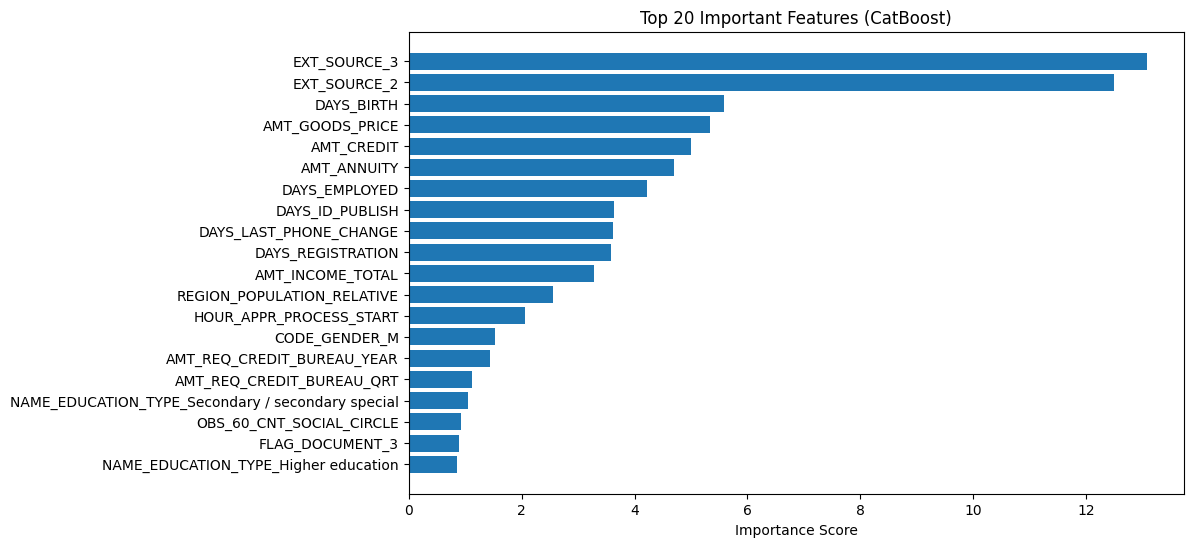

In [17]:
# Get feature importance
import matplotlib.pyplot as plt

feature_importance = model_cb.get_feature_importance()
features = X.columns

# Combine and sort
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features (CatBoost)")
plt.xlabel("Importance Score")
plt.show()


In [18]:
# Align test set with training features
X_test_final = X_test_final.reindex(columns=X.columns, fill_value=-999)

# Predict probabilities and apply optimal threshold
test_probs = model_cb.predict_proba(X_test_final)[:, 1]
test_preds = (test_probs >= optimal_threshold).astype(int)

# Load SK_ID_CURR to match submission format
submission = pd.read_csv("/content/application_test.csv")[['SK_ID_CURR']]
submission['TARGET'] = test_preds

# Save submission file
submission.to_csv("loan_default_predictions.csv", index=False)
print("Submission file saved as loan_default_predictions.csv")


Submission file saved as loan_default_predictions.csv


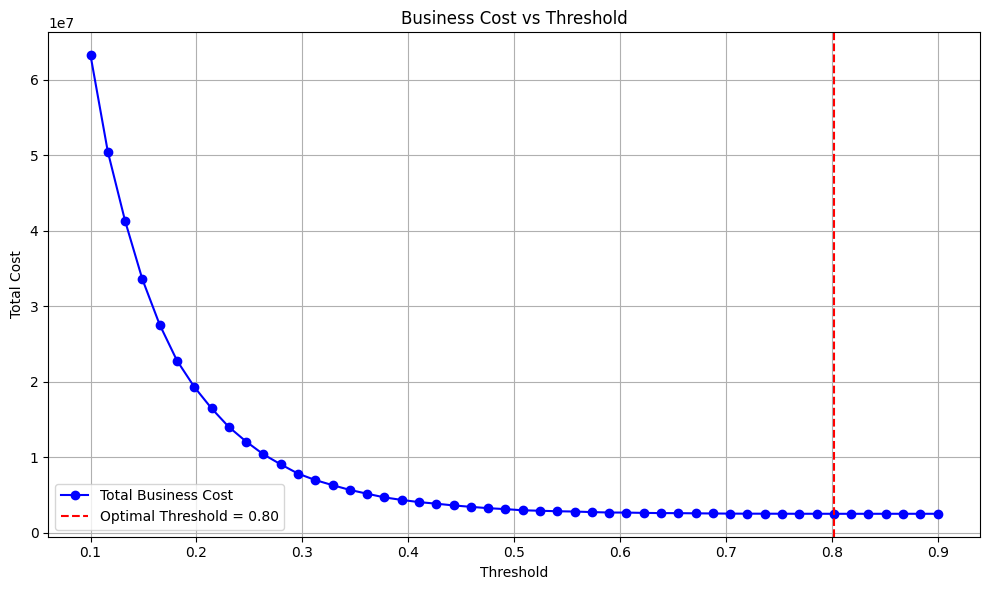

In [19]:
import matplotlib.pyplot as plt

# Plotting the threshold vs total business cost
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, marker='o', linestyle='-', color='blue', label='Total Business Cost')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.title('Business Cost vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Total Cost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**TASK 5**

In [7]:
# Install dependencies
!pip install streamlit openpyxl plotly pyngrok
!npm install -g localtunnel


⠙⠹⠸⠼⠴⠦
added 22 packages in 1s
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦

In [8]:
# Save Streamlit code to dashboard.py
dashboard_code = """
import streamlit as st
import pandas as pd
import plotly.express as px

# Load Data
df = pd.read_excel("Global_Superstore2.xlsx")

# Clean & Prepare
df = df.dropna(subset=['Sales', 'Profit', 'Customer Name', 'Region', 'Category', 'Sub-Category'])

# Sidebar Filters
st.sidebar.title("Filters")
region = st.sidebar.multiselect("Select Region", options=df['Region'].unique(), default=df['Region'].unique())
category = st.sidebar.multiselect("Select Category", options=df['Category'].unique(), default=df['Category'].unique())
sub_category = st.sidebar.multiselect("Select Sub-Category", options=df['Sub-Category'].unique(), default=df['Sub-Category'].unique())

# Filtered Data
filtered_df = df[
    (df['Region'].isin(region)) &
    (df['Category'].isin(category)) &
    (df['Sub-Category'].isin(sub_category))
]

# Main Title
st.title("📊 Global Superstore Dashboard")

# KPIs
total_sales = filtered_df['Sales'].sum()
total_profit = filtered_df['Profit'].sum()
top_customers = filtered_df.groupby('Customer Name')['Sales'].sum().sort_values(ascending=False).head(5)

# Display KPIs
st.metric("💰 Total Sales", f"${total_sales:,.2f}")
st.metric("📈 Total Profit", f"${total_profit:,.2f}")

# Top Customers
st.subheader("🏆 Top 5 Customers by Sales")
st.bar_chart(top_customers)

# Sales by Category
st.subheader("📦 Sales by Category")
fig1 = px.bar(filtered_df.groupby('Category')['Sales'].sum().reset_index(), x='Category', y='Sales', color='Category')
st.plotly_chart(fig1)

# Profit by Region
st.subheader("🌍 Profit by Region")
fig2 = px.pie(filtered_df.groupby('Region')['Profit'].sum().reset_index(), values='Profit', names='Region')
st.plotly_chart(fig2)
"""
with open("dashboard.py", "w") as f:
    f.write(dashboard_code)


In [9]:
# Start Streamlit app in the background
import os
os.system('streamlit run dashboard.py &')


0

In [ ]:
# Open it using a unique subdomain to avoid password protection
!npx localtunnel --port 8501 --subdomain gsdashboard$(date +%s)


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸your url is: https://gsdashboard1753036681.loca.lt
